# TASK 1

In [76]:
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
onlineclothing=pd.read_csv(r"C:\Users\Hammad Malik\Documents\onlineclothing.csv")
countries=pd.read_csv(r"C:\Users\Hammad Malik\Documents\countries.csv")

data = pd.merge(onlineclothing, countries, on='id')

In [3]:
# preview the merged data
print(data.head())

       id time stamp  con_treat      page  converted country
0  851104    11:48.6    control  old_page          0      US
1  804228    01:45.2    control  old_page          0      US
2  661590    55:06.2  treatment  new_page          0      US
3  853541    28:03.1  treatment  new_page          0      US
4  864975    52:26.2    control  old_page          1      US


In [4]:
data.shape

(294478, 6)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294478 entries, 0 to 294477
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          294478 non-null  int64 
 1   time stamp  294478 non-null  object
 2   con_treat   294478 non-null  object
 3   page        294478 non-null  object
 4   converted   294478 non-null  int64 
 5   country     294478 non-null  object
dtypes: int64(2), object(4)
memory usage: 11.2+ MB


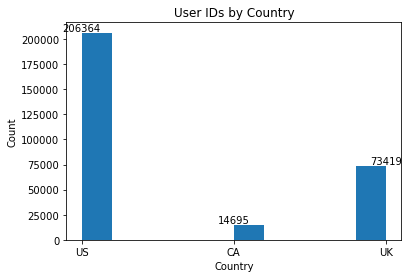

In [6]:
# create a histogram of user IDs by country
plt.hist(data['country'])
plt.title('User IDs by Country')
plt.xlabel('Country')
plt.ylabel('Count')
for i, country in enumerate(data['country'].unique()):
    count = data[data['country'] == country]['id'].count()
    plt.text(i, count + 10, str(count), ha='center', va='bottom')
plt.show()

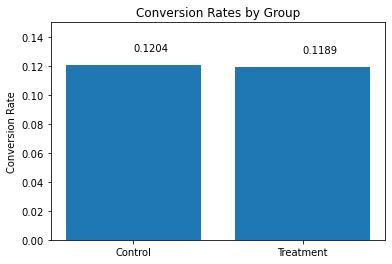

In [12]:
# Calculate the conversion rates for each group
control_rate = data[data['con_treat'] == 'control']['converted'].mean()
treatment_rate = data[data['con_treat'] == 'treatment']['converted'].mean()

# Create a bar chart of the conversion rates
plt.bar(['Control', 'Treatment'], [control_rate, treatment_rate])
plt.title('Conversion Rates by Group')
plt.ylabel('Conversion Rate')
plt.ylim(0, 0.15)
plt.text(0, control_rate + 0.01, f'{control_rate:.4f}')
plt.text(1, treatment_rate + 0.01, f'{treatment_rate:.4f}')
plt.show()

In [9]:
# split the data into control and treatment groups

# A/B testing on A and B website homepages according to different countries

A_homepage = 'old_page'

B_homepage = 'new_page'

control = data[data['page'] == A_homepage]
treatment = data[data['page'] == B_homepage]

# loop through each country and calculate conversion rates
for country in data['country'].unique():
    # filter the data by country and control/treatment groups
    country_control = control[control['country'] == country]['converted']
    country_treatment = treatment[treatment['country'] == country]['converted']

    # calculate the conversion rates for each group
    control_rate = country_control.mean()
    treatment_rate = country_treatment.mean()

    # conduct a hypothesis test to determine whether the difference in rates of hamepages is significant
    p_value = stats.ttest_ind(country_control, country_treatment)[1]
     # print the results
    print(f'Country: {country}')
    print(f'Control conversion rate: {control_rate:.4f}')
    print(f'Treatment conversion rate: {treatment_rate:.4f}')
    print(f'P-value: {p_value:.4f}')
    if p_value < 0.05:
        print('Statistically significant difference\n')
    else:
        print('No statistically significant difference\n')

Country: US
Control conversion rate: 0.1208
Treatment conversion rate: 0.1184
P-value: 0.0971
No statistically significant difference

Country: CA
Control conversion rate: 0.1193
Treatment conversion rate: 0.1125
P-value: 0.1946
No statistically significant difference

Country: UK
Control conversion rate: 0.1198
Treatment conversion rate: 0.1213
P-value: 0.5365
No statistically significant difference



# Task 2

In [101]:
import requests
from bs4 import BeautifulSoup
import re
import pytesseract
from PIL import Image
from io import BytesIO
from unidecode import unidecode

In [92]:
pip install pytesseract


Note: you may need to restart the kernel to use updated packages.


In [105]:


def extract_emails_from_text(text):
    # Regular expression to extract email addresses with variations
    email_pattern = (
        r"[a-zA-Z0-9_.+-]+(?:\s*@\s*|\s*\[?\s*[\ufeff]?[aA]t\s*[\ufeff]?\s*\]?\s*|\s*\[?\s*[\ufeff]?[äÄ]t\s*[\ufeff]?\s*\]?\s*|\s*[\ufeff]?)"
        r"[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+"
    )
    emails = re.findall(email_pattern, text)
    return [unidecode(email.lower().replace('[at]', '@').replace(' at ', '@').replace('ät', '@').replace(' [ät] ', '@')) for email in emails]

def extract_emails_from_image(image_url):
    page = requests.get(image_url)
    image_content = page.content
    image = Image.open(BytesIO(image_content))
    text = pytesseract.image_to_string(image)
    return extract_emails_from_text(text)

def scrape_emails_from_domain(domain):
    try:
        url = f"https://{domain}/impressum"
        page = requests.get(url)
        soup = BeautifulSoup(page.content, "html.parser")
        text = soup.get_text()
        emails_from_text = extract_emails_from_text(text)
        
        # Search for email in images
        emails_from_images = []
        for img in soup.find_all("img"):
            src = img.get("src")
            if src and src.startswith("http"):
                emails_from_image = extract_emails_from_image(src)
                emails_from_images.extend(emails_from_image)

        return list(set(emails_from_text + emails_from_images))
    except Exception as e:
        print(f"Error processing domain '{domain}': {e}")
        return []

if __name__ == "__main__":
    domains = [
        'peersociallending.com', 'malta-tours.de', 'wiseclerk.com',
        'example.com', 'example.org', 'example.net', 'google.com', 'yahoo.com',
        'facebook.com'
    ]

    all_emails = {}
    for domain in domains:
        emails = scrape_emails_from_domain(domain)
        if emails:
            all_emails[domain] = emails

    # Create DataFrame with Domain and Email columns (Optional)
    import pandas as pd
    df = pd.DataFrame(all_emails.items(), columns=['Domain', 'Emails'])
    print(df)

    # Output to Excel (Optional)
    df.to_excel('emails.xlsx', sheet_name='Emails', index=False)
    print("Results written to emails.xlsx")


                  Domain                                  Emails
0  peersociallending.com  [2.4.29, server@peersociallending.com]
1            example.com                   [more information...]
2            example.org                   [more information...]
3            example.net                   [more information...]
Results written to emails.xlsx


# Task 3

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
df=pd.read_csv("Retail_services.csv")
df

,time.index,time.month,time.month name,time.period,time.year,data.inventories.all department stores,data.inventories.all other home furnishings stores,data.inventories.all other merchandise stores,data.inventories.appliances and other electronics stores,data.inventories.auto and other motor vehicles,...,"data.sales.retail trade and food services, ex auto","data.sales.retail trade, ex auto",data.sales.shoe stores,data.sales.sporting goods stores,"data.sales.sporting goods, hobby, book, and music stores",data.sales.supermarkets and other grocery (except convenience) stores,data.sales.used car dealers,data.sales.used merchandise stores,data.sales.warehouse clubs and superstores,data.sales.women's clothing stores
0,1,1,Jan,Jan1992,1992,0,0,0,0,0,...,116565,100872,1206,972,3439,0,1744,371,2579,1873
1,2,2,Feb,Feb1992,1992,0,0,0,0,0,...,115862,100027,1265,1100,3264,0,1990,402,2615,1991
2,3,3,Mar,Mar1992,1992,0,0,0,0,0,...,124200,107352,1463,1214,3473,0,2177,419,2838,2403
3,4,4,Apr,Apr1992,1992,0,0,0,0,0,...,127587,111093,1675,1267,3523,0,2601,393,2984,2665
4,5,5,May,May1992,1992,0,0,0,0,0,...,133608,115960,1560,1293,3545,0,2171,435,3257,2752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,285,9,Sep,Sep2015,2015,0,0,0,0,0,...,338500,287804,2565,3623,7125,47244,7094,1497,34745,3549
285,286,10,Oct,Oct2015,2015,0,0,0,0,0,...,353708,299714,2663,3406,6738,48964,7283,1633,37352,3878
286,287,11,Nov,Nov2015,2015,0,0,0,0,0,...,359528,309281,2827,3860,8025,48505,6605,1413,39731,4172
287,288,12,Dec,Dec2015,2015,0,0,0,0,0,...,423095,368440,3985,6444,13025,51216,6507,1436,45540,5507


In [42]:
# seperating all columns that have all rows equals to 0
zero_cols = df.columns[df.eq(0).all()]
print(len(zero_cols))
# dropping zero_cols
df.drop(zero_cols, axis=1, inplace=True)
df.head()

110


,time.index,time.month,time.month name,time.period,time.year,data.inventories.building materials and garden supplies dealers,data.inventories.clothing stores,data.inventories.food and beverage stores,"data.inventories.furniture, home furn, electronics, and appliance stores",data.inventories.general merchandise stores,...,"data.sales.retail trade and food services, ex auto","data.sales.retail trade, ex auto",data.sales.shoe stores,data.sales.sporting goods stores,"data.sales.sporting goods, hobby, book, and music stores",data.sales.supermarkets and other grocery (except convenience) stores,data.sales.used car dealers,data.sales.used merchandise stores,data.sales.warehouse clubs and superstores,data.sales.women's clothing stores
0,1,1,Jan,Jan1992,1992,19545,22622,26963,13850,43750,...,116565,100872,1206,972,3439,0,1744,371,2579,1873
1,2,2,Feb,Feb1992,1992,20177,24047,26674,13657,44275,...,115862,100027,1265,1100,3264,0,1990,402,2615,1991
2,3,3,Mar,Mar1992,1992,20830,24716,26700,14279,46296,...,124200,107352,1463,1214,3473,0,2177,419,2838,2403
3,4,4,Apr,Apr1992,1992,21262,25269,26934,14486,47488,...,127587,111093,1675,1267,3523,0,2601,393,2984,2665
4,5,5,May,May1992,1992,21003,24938,26979,14610,45901,...,133608,115960,1560,1293,3545,0,2171,435,3257,2752


In [43]:
df.describe()

,time.index,time.month,time.year,data.inventories.building materials and garden supplies dealers,data.inventories.clothing stores,data.inventories.food and beverage stores,"data.inventories.furniture, home furn, electronics, and appliance stores",data.inventories.general merchandise stores,data.inventories.motor vehicle and parts dealers,data.inventories.non-leased department stores,...,"data.sales.retail trade and food services, ex auto","data.sales.retail trade, ex auto",data.sales.shoe stores,data.sales.sporting goods stores,"data.sales.sporting goods, hobby, book, and music stores",data.sales.supermarkets and other grocery (except convenience) stores,data.sales.used car dealers,data.sales.used merchandise stores,data.sales.warehouse clubs and superstores,data.sales.women's clothing stores
count,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,...,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000
mean,145.000000,6.480969,2003.543253,37448.332180,38768.211073,34362.747405,25135.688581,67767.173010,127702.847751,37304.851211,...,242476.089965,211132.491349,2089.602076,2498.768166,6208.961938,25135.124567,5144.723183,861.743945,19464.089965,2957.148789
std,83.571327,3.467180,6.961130,9488.576915,8190.613704,5209.401515,4387.337131,10675.075145,33866.861390,6150.632957,...,72916.757891,63030.803887,500.439124,934.727674,1815.035633,19902.112653,1631.006836,276.348091,11796.867031,719.518344
min,1.000000,1.000000,1992.000000,19545.000000,22622.000000,26476.000000,13657.000000,43750.000000,61994.000000,26733.000000,...,115862.000000,100027.000000,1161.000000,972.000000,3204.000000,0.000000,1583.000000,371.000000,2579.000000,1565.000000
25%,73.000000,3.000000,1998.000000,28847.000000,31652.000000,30302.000000,22247.000000,59858.000000,100710.000000,33373.000000,...,177182.000000,155484.000000,1757.000000,1754.000000,5227.000000,0.000000,4066.000000,702.000000,7758.000000,2440.000000
50%,145.000000,6.000000,2004.000000,37913.000000,39244.000000,33159.000000,25657.000000,68424.000000,128078.000000,37138.000000,...,240415.000000,210772.000000,2006.000000,2319.000000,6004.000000,34485.000000,5348.000000,811.000000,19000.000000,2780.000000
75%,217.000000,9.000000,2010.000000,46177.000000,45411.000000,37791.000000,27710.000000,74705.000000,155323.000000,41514.000000,...,301828.000000,260358.000000,2356.000000,3109.000000,6652.000000,41657.000000,6339.000000,983.000000,30329.000000,3415.000000
max,289.000000,12.000000,2016.000000,54049.000000,57920.000000,47491.000000,35746.000000,95211.000000,202093.000000,52384.000000,...,423095.000000,368440.000000,3985.000000,6444.000000,13025.000000,51216.000000,8762.000000,1633.000000,45540.000000,5606.000000


In [44]:
df.isnull().sum()

time.index                                                               0
time.month                                                               0
time.month name                                                          0
time.period                                                              0
time.year                                                                0
                                                                        ..
data.sales.supermarkets and other grocery (except convenience) stores    0
data.sales.used car dealers                                              0
data.sales.used merchandise stores                                       0
data.sales.warehouse clubs and superstores                               0
data.sales.women's clothing stores                                       0
Length: 87, dtype: int64

In [45]:
#How has retail economic activity in the United States changed over the past five years?
df_economic=df[(df['time.year'] >= 2011) & (df['time.year'] <= 2016)]
df_economic


,time.index,time.month,time.month name,time.period,time.year,data.inventories.building materials and garden supplies dealers,data.inventories.clothing stores,data.inventories.food and beverage stores,"data.inventories.furniture, home furn, electronics, and appliance stores",data.inventories.general merchandise stores,...,"data.sales.retail trade and food services, ex auto","data.sales.retail trade, ex auto",data.sales.shoe stores,data.sales.sporting goods stores,"data.sales.sporting goods, hobby, book, and music stores",data.sales.supermarkets and other grocery (except convenience) stores,data.sales.used car dealers,data.sales.used merchandise stores,data.sales.warehouse clubs and superstores,data.sales.women's clothing stores
228,229,1,Jan,Jan2011,2011,42217,39587,38945,26552,68594,...,277963,240969,1784,2411,6263,42580,5968,944,28856,2432
229,230,2,Feb,Feb2011,2011,44082,40920,38178,25117,69072,...,274963,237538,2195,2454,5371,39561,7286,1030,28961,2854
230,231,3,Mar,Mar2011,2011,46500,42077,38670,25818,72666,...,312098,270031,2388,3264,6326,43189,7650,1183,31023,3579
231,232,4,Apr,Apr2011,2011,46977,41689,38915,26257,72687,...,311384,269592,2431,3244,6151,43624,6439,1065,31438,3718
232,233,5,May,May2011,2011,45763,41921,39142,26021,72144,...,322866,279813,2330,3166,6081,44220,6254,1063,32359,3644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,285,9,Sep,Sep2015,2015,51777,56030,45209,27510,87715,...,338500,287804,2565,3623,7125,47244,7094,1497,34745,3549
285,286,10,Oct,Oct2015,2015,52293,57920,46784,29723,95211,...,353708,299714,2663,3406,6738,48964,7283,1633,37352,3878
286,287,11,Nov,Nov2015,2015,51358,57849,47491,31844,94862,...,359528,309281,2827,3860,8025,48505,6605,1413,39731,4172
287,288,12,Dec,Dec2015,2015,50184,50722,45836,27514,80123,...,423095,368440,3985,6444,13025,51216,6507,1436,45540,5507


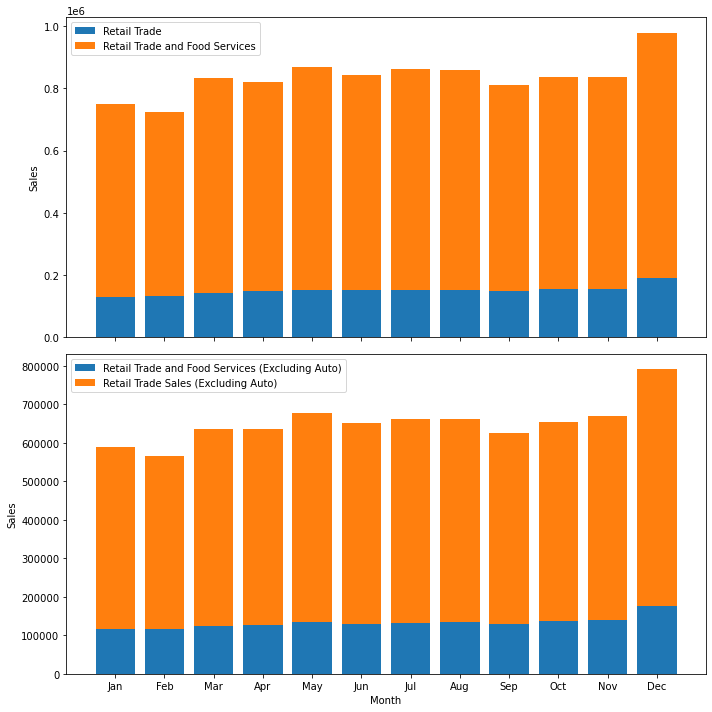

In [50]:
#Can we identify any seasonal patterns or trends in monthly retail sales data?
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
axs[0].bar(df['time.month name'], df['data.sales.retail trade'], label='Retail Trade')
axs[0].bar(df['time.month name'], df['data.sales.retail trade and food services'], bottom=df['data.sales.retail trade'], label='Retail Trade and Food Services')
axs[0].set_ylabel('Sales')
axs[0].legend()

axs[1].bar(df['time.month name'], df['data.sales.retail trade and food services, ex auto'], label='Retail Trade and Food Services (Excluding Auto)')
axs[1].bar(df['time.month name'], df['data.sales.retail trade, ex auto'], bottom=df['data.sales.retail trade and food services, ex auto'], label='Retail Trade Sales (Excluding Auto)')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Sales')
axs[1].legend()

plt.tight_layout()
plt.show()



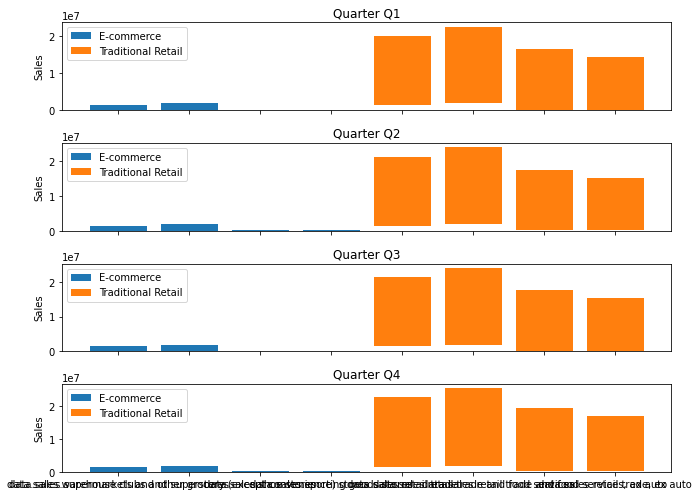

In [66]:
#How does e-commerce activity compare to traditional retail sales on a quarterly basis?
# Create a new 'time' column by combining 'time.year' and 'time.month'
df['time'] = pd.to_datetime(df['time.year'].astype(str) + '-' + df['time.month'].astype(str))

# Extract the quarter from the 'time' column
df['quarter'] = df['time'].dt.quarter

# Map numerical quarters to corresponding string labels
quarter_labels = {1: 'Q1', 2: 'Q2', 3: 'Q3', 4: 'Q4'}
df['quarter'] = df['quarter'].map(quarter_labels)

# Select the relevant sales columns for e-commerce and traditional retail
ecommerce_columns= [
   'data.sales.warehouse clubs and superstores',
    'data.sales.supermarkets and other grocery (except convenience) stores',
    'data.sales.shoe stores',
    'data.sales.sporting goods stores',
]

traditional_columns = [
    'data.sales.retail trade',
    'data.sales.retail trade and food services',
    'data.sales.retail trade and food services, ex auto',
    'data.sales.retail trade, ex auto',
    # Add other traditional retail-related columns as needed
]

# Group the data by quarter and calculate the total sales for each category within each quarter
ecommerce_quarterly_sales = df.groupby('quarter')[ecommerce_columns].sum()
traditional_quarterly_sales = df.groupby('quarter')[traditional_columns].sum()

# Create a bar plot to compare quarterly e-commerce and traditional retail sales
quarters = ['Q1', 'Q2', 'Q3', 'Q4']
num_quarters = len(quarters)

fig, axs = plt.subplots(num_quarters, 1, figsize=(10, 7), sharex=True)
for i, quarter in enumerate(quarters):
    axs[i].bar(ecommerce_columns, ecommerce_quarterly_sales.loc[quarter], label='E-commerce')
    axs[i].bar(traditional_columns, traditional_quarterly_sales.loc[quarter], bottom=ecommerce_quarterly_sales.loc[quarter], label='Traditional Retail')
    axs[i].set_ylabel('Sales')
    axs[i].set_title(f'Quarter {quarter}')
    axs[i].legend()

plt.tight_layout()
plt.show()



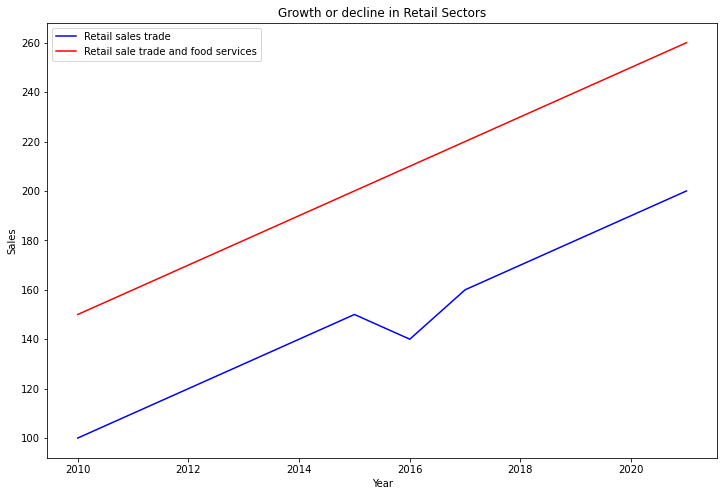

Sector with significant growth:
time.year                                     2021.000000
data.sales.retail trade                        200.000000
data.sales.retail trade and food services      260.000000
growth_rate.retail trade                         5.263158
growth_rate.retail trade and food services       4.000000
Name: 11, dtype: float64

Sector with significant decline:
time.year                                     2016.000000
data.sales.retail trade                        140.000000
data.sales.retail trade and food services      210.000000
growth_rate.retail trade                        -6.666667
growth_rate.retail trade and food services       5.000000
Name: 6, dtype: float64


In [75]:
#Are there any specific retail sectors that have shown significant growth or decline in recent years?
plt.figure(figsize=(12, 8))
plt.plot(df['time.year'], df['data.sales.retail trade'], 'b-', label = 'Retail sales trade')
plt.plot(df['time.year'], df['data.sales.retail trade and food services'], 'r-', label = 'Retail sale trade and food services')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Growth or decline in Retail Sectors')
plt.legend()
plt.show()
# Calculate the growth rates for each retail sector
df['growth_rate.retail trade'] = df['data.sales.retail trade'].pct_change() * 100
df['growth_rate.retail trade and food services'] = df['data.sales.retail trade and food services'].pct_change() * 100

# Determine significant growth or decline based on growth rates
significant_growth_sector = df[df['growth_rate.retail trade'] > 0]['data.sales.retail trade'].idxmax()
significant_decline_sector = df[df['growth_rate.retail trade'] < 0]['data.sales.retail trade'].idxmin()

# Print the results
print("Sector with significant growth:")
print(df.loc[significant_growth_sector])

print("\nSector with significant decline:")
print(df.loc[significant_decline_sector])



In [78]:
#What is the overall contribution of retail trade to the United States' GDP?
overall_retail = df.sum()
# Display the overall retail column totals
print(overall_retail)

time.year                                     24186.000000
data.sales.retail trade                        1790.000000
data.sales.retail trade and food services      2460.000000
growth_rate.retail trade                         72.829521
growth_rate.retail trade and food services       56.439585
dtype: float64


How do retail operating expenses vary across different types of businesses?

Operating expenses is basically that type of expenses in which companies earns during their normal day to day operations. Retail operating expenses may vary along with different type of business within the retail sectors.

Retailers with a warehouse have higher operating expenses rather than the inventory storage units or restocking. Businesses with higher inventory turnover may also incur more frequent restocking and procurement costs.
Larger retailers establishment have higher operating expenses due to higher rent, labour cost and utility bills etc. Whether if the store is located on a prime area with high operating expenses or in a more affordable location. 
The level of investment in tech infrastructure varies, ranging from simple self-checkout systems to comprehensive integrated back-end systems.

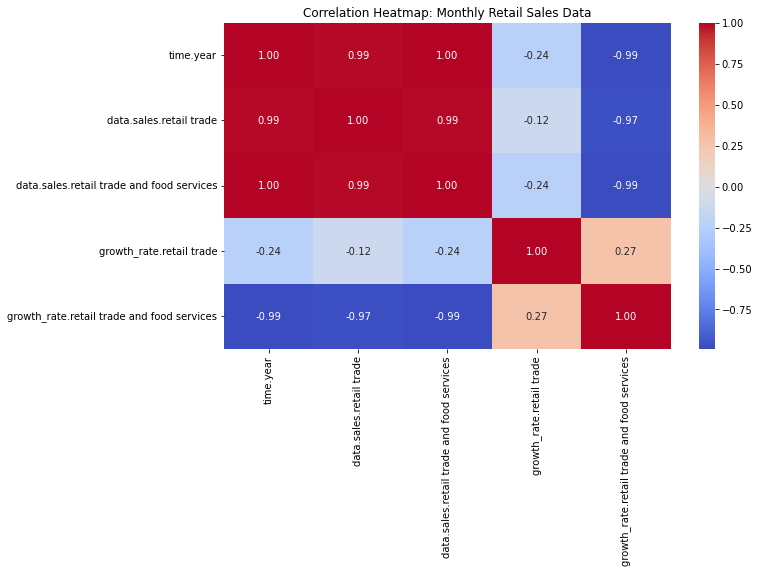

In [87]:
#What are the main factors influencing fluctuations in monthly retail sales data?
# Filter the data for retail sales
retail = df.filter(like='data.sales.retail')
correlation_matrix = df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap: Monthly Retail Sales Data')
plt.show()
